In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
from step7.Ecommerce7 import*

## Step 2

In [ ]:
simulate_step2()

## Step 3

In [3]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, gpts_max_variance_per_experiment, gpucb_max_variance_per_experiment = simulate_step3()

Experiment n°: 0


Experiment n°: 1


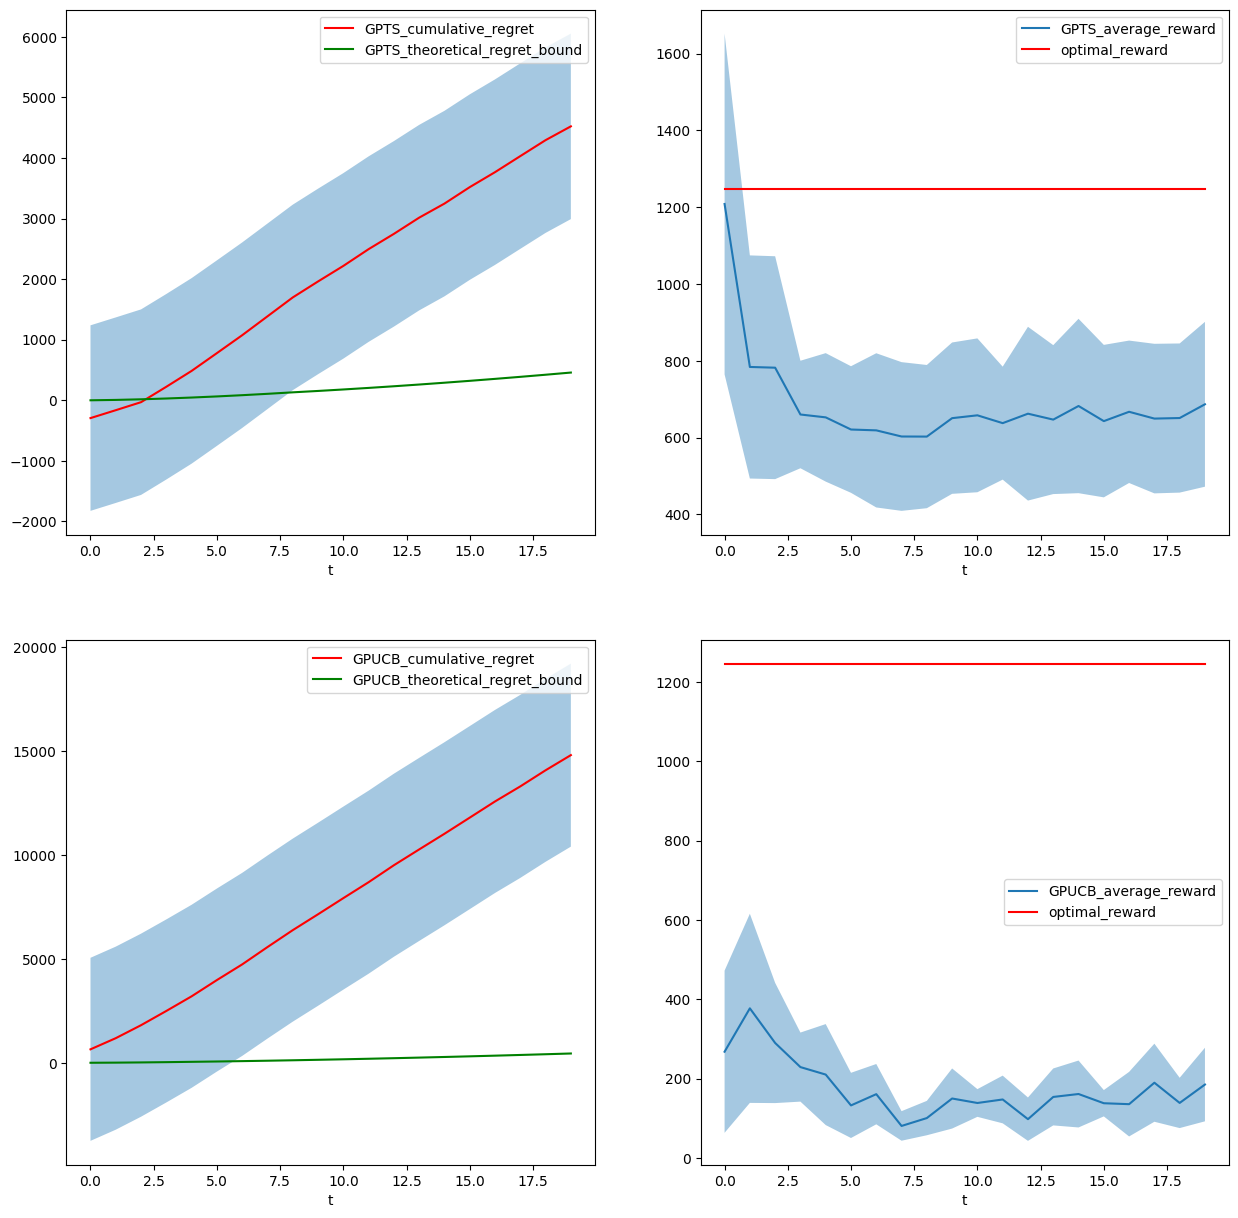

In [23]:
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, gpts_max_variance_per_experiment, gpucb_max_variance_per_experiment, ["GPTS", "GPUCB"])

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

In [ ]:
gpucb_rewards_per_experiment, gpts_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

Experiment n° 0


Experiment n° 1


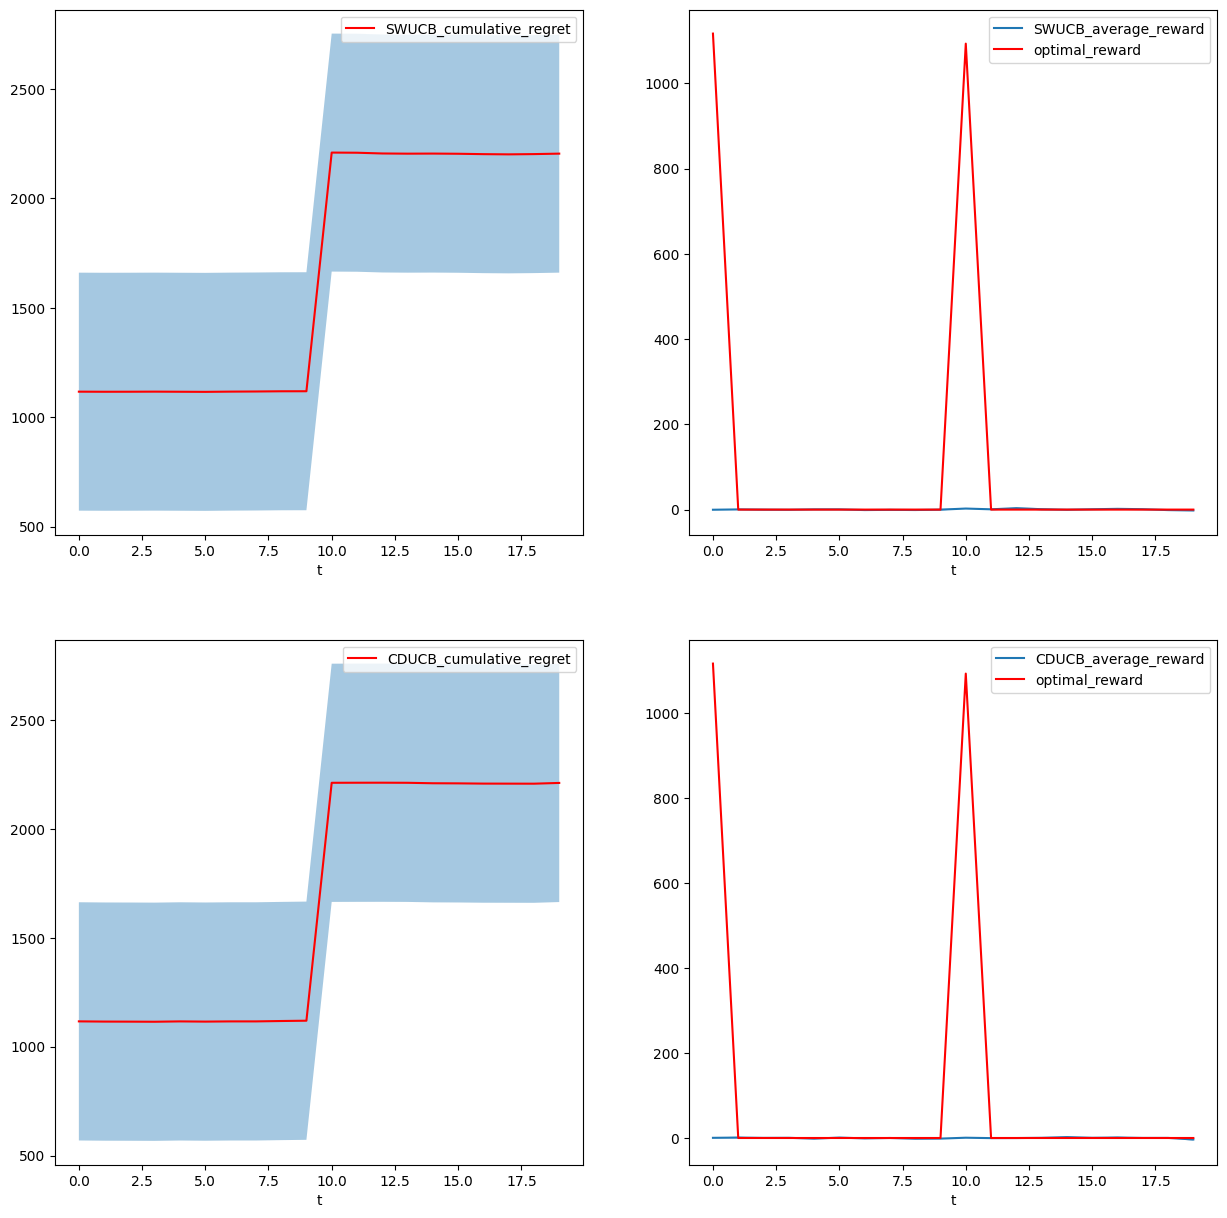

In [2]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"])

## Step 7

In [ ]:

env, observations_probabilities, click_probabilities, product_prices,\
    users_reservation_prices, users_poisson_parameters = generate_new_environment()


nodes_activation_probabilities, num_sold_items = estimate_nodes_activation_probabilities(
    click_probabilities,
    users_reservation_prices,
    users_poisson_parameters,
    product_prices,
    observations_probabilities
)

exp_num_clicks = env.estimate_disaggregated_num_clicks(budgets/B_cap)

ecomm7 = Ecommerce7(B_cap, budgets, product_prices, features, 'TS')
_, optimal_reward = ecomm7.clairvoyant_solve_optimization_problem(num_sold_items,
                                                                  exp_num_clicks,
                                                                  nodes_activation_probabilities)

ts_gains_per_experiment = np.zeros(shape=T)

for t in tqdm(range(0, T), position=0, desc="n_iteration", leave=True):
    context_learners = ecomm7.get_context_tree().get_leaves()
    idxs = []
    pulled_arms = np.zeros(shape=(NUM_OF_USERS_CLASSES, NUM_OF_PRODUCTS))

    if t % split_time == 0 and t != 0:
        for learner in context_learners:
            learner.evaluate_splitting_condition(features,
                                                 ecomm7.get_pulled_arms(
                                                 )[-split_time:],
                                                 ecomm7.get_collected_rewards(
                                                 )[-split_time:],
                                                 ecomm7.get_collected_sold_items()[-split_time:])

        context_learners = ecomm7.get_context_tree().get_leaves()

    
    for learner in context_learners:
        arm, idx = learner.pull_arm()
        idxs.append(idx)
        pulled_arms[idx, :] = arm

    reward, estimated_sold_items = env.round_step7(
        pulled_arms, B_cap, nodes_activation_probabilities, num_sold_items)

    for i in range(len(context_learners)):
        context_learners[i].update(
            pulled_arms[idxs[i][0]],
            np.sum(reward[idxs[i]], axis=0),
            np.sum(estimated_sold_items[idxs[i]], axis=0)
        )

    ecomm7.update_history(pulled_arms, reward, estimated_sold_items)
    for learner in context_learners:
        _, rew = learner.algorithm.solve_optimization_problem(nodes_activation_probabilities)
        ts_gains_per_experiment[t] += rew


In [ ]:
alg1_regret = np.cumsum((optimal_reward-ts_gains_per_experiment))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ticks = np.arange(start=1, stop=len(alg1_regret) + 1, step=1)

ax[0].plot(ticks, alg1_regret, color='r')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Regret')

    
plt.show()